# Multilabel Classification for Event Extraction

In [5]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import pickle
import numpy as np
import re
import nltk
import string

import pandas as pd
import numpy as np
from tqdm import tqdm

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import time 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from util import * 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Section 1: Data Preprocessing

In [3]:
mypath = "data/NTSB"
Occurrences = pd.read_csv(mypath+'/Occurrences.csv')
Events_Sequence = pd.read_csv(mypath+'/Events_Sequence.csv') # RECORDING FOR POST-2008
sequence = pd.read_csv(mypath+'/seq_of_events.csv')
aircraft = pd.read_csv(mypath+'/aircraft.csv')
events = pd.read_csv(mypath+'/events.csv')
DataDict = pd.read_csv(mypath+'/eADMSPUB_DataDictionary.csv')
narratives = pd.read_csv(mypath+'/narratives.csv')
# select key columns
events_select = events[['ev_id','ev_highest_injury','ev_year']]
aircraft_select = aircraft[['ev_id', 'Aircraft_Key', 'damage']]
Occurrences_select = Occurrences[['ev_id', 'Aircraft_Key', 'Occurrence_No', 'Occurrence_Code',
       'Phase_of_Flight']]
sequence_select = sequence[['ev_id', 'Aircraft_Key', 'Occurrence_No','seq_event_no','Subj_Code','Modifier_Code']]
# Merge tables according to event id, occurrence number, aircraft id
merge_buffer = pd.merge(Occurrences_select, sequence_select, on=['ev_id', 'Aircraft_Key', 'Occurrence_No'])
merge_buffer = pd.merge(merge_buffer, aircraft_select, on=['ev_id', 'Aircraft_Key'])
data = pd.merge(merge_buffer, events_select, on=['ev_id'])

data_select = data[data['ev_year']<=2008]
data_group = data_select.groupby(['ev_id','Aircraft_Key'])['Occurrence_No','Occurrence_Code','Phase_of_Flight','Subj_Code','damage','ev_highest_injury','ev_year'].agg(lambda x: x.tolist()).reset_index()
data_final = pd.merge(data_group, narratives, on=['ev_id', 'Aircraft_Key'])

/home/xinyu/miniconda3/envs/aiaa/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [8]:
predict_type ='Occurrence_Code'
# predict_type ='Subj_Code'
# predict_type = 'Phase_of_Flight'
MAX_LENGTH = 20
data_final = data_final.dropna(subset=['narr_accf'])
data_final = data_final.dropna(subset=[predict_type])
data_final['narr_accf'] = data_final['narr_accf'].replace('\\n', '', regex=True)
data_final['narr_accf'] =  data_final['narr_accf'].replace('\\r', '', regex=True)
data_filter = data_final[[len(x.split('.'))<=MAX_LENGTH for x in data_final['narr_accf']]].reset_index()
for i, row in tqdm(data_filter.iterrows(), total=data_filter.shape[0], position=0):
    sentence = data_filter.at[i,'narr_accf']
    sentence = re.sub('[^A-Za-z0-9.-]+', ' ', sentence)
    #Remove whitespaces
    sentence = sentence.strip()
    sentence = nltk.word_tokenize(sentence)
    # Remove stop words
    sentence = [i for i in sentence if not i in stop_words]
    # Stemming and Lemmatization
    data_buffer = []
    for word in sentence:
#         word_ = stemmer.stem(word)
        word_ = lemmatizer.lemmatize(word_)
        data_buffer.append(word_)
    data_filter.at[i,'narr_accf'] = ' '.join(data_buffer)
    # add phase information
    phase_set = set(data_filter.at[i,'Phase_of_Flight'])
    buffer = data_filter.at[i,'narr_accf']
    for x in phase_set:
        if list(DataDict[DataDict['code_iaids']==str(x)]['meaning']):
            buffer += ' ' + list(DataDict[DataDict['code_iaids']==str(x)]['meaning'])[0]
    data_filter.at[i,'narr_accf'] = buffer
data_final = data_filter
occurrence_corpus = list(set([item for sublist in data_final[predict_type] for item in sublist]))

100%|██████████| 61490/61490 [06:12<00:00, 165.05it/s]


## Section 2: Modeling

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_final, test_size=0.2,random_state= 42)

train_x = list(train['narr_accf'])
test_x = list(test['narr_accf'])
train_y = []
test_y = []
for idx, row in tqdm(train.iterrows(), total=train.shape[0], position=0):
    train_y.append(list(set(train.at[idx,predict_type])))

for idx, row in tqdm(test.iterrows(), total=test.shape[0], position=0):
    test_y.append(list(set(test.at[idx,predict_type])))


mlb = MultiLabelBinarizer()
train_y = mlb.fit_transform(train_y)
test_y = mlb.transform(test_y)
model_list = [RandomForestClassifier(), GradientBoostingClassifier(), MultinomialNB(), LinearSVC(), KNeighborsClassifier(), DecisionTreeClassifier(),BaggingClassifier()]
mode_name = ['RandomForestClassifier', 'GradientBoostingClassifier', 'MultinomialNB', 'LinearSVC', 'KNeighborsClassifier', 'DecisionTreeClassifier','BaggingClassifier']

100%|██████████| 12298/12298 [00:01<00:00, 11284.96it/s]


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

vectorizer = TfidfVectorizer(ngram_range=(1,1))
train_x_vector_raw = vectorizer.fit_transform(train_x)
test_x_vector_raw = vectorizer.transform(test_x)
# reducer = umap.UMAP()
# embedding = reducer.fit_transform(train_x_vector)


train_x_vector = train_x_vector_raw
test_x_vector = test_x_vector_raw

In [18]:
start = time.time()
ii = 3
classifier =  OneVsRestClassifier(model_list[ii])
classifier.fit(train_x_vector, train_y)
end = time.time()
total_time = end - start

## Section 3: Result Analysis

In [23]:
predicted = classifier.predict(train_x_vector)
metricsReport(mode_name[ii]+'+_train',train_y, predicted, total_time)
predicted = classifier.predict(test_x_vector)
metricsReport(mode_name[ii]+'+_test',test_y, predicted, total_time)

------LinearSVC+_train Model Metrics-----
AUC: 0.8504
, Accuracy: 0.5379
Hamming Loss: 0.0115
Precision:
  - Macro: 0.9673
  - Micro: 0.9066
Recall:
  - Macro: 0.7131
  - Micro: 0.7031
F1-measure:
  - Macro: 0.7936
  - Micro: 0.7920


/home/xinyu/miniconda3/envs/aiaa/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xinyu/miniconda3/envs/aiaa/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xinyu/miniconda3/envs/aiaa/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


------LinearSVC+_test Model Metrics-----
AUC: 0.7418
, Accuracy: 0.2889
Hamming Loss: 0.0218
Precision:
  - Macro: 0.4771
  - Micro: 0.7241
Recall:
  - Macro: 0.2529
  - Micro: 0.4897
F1-measure:
  - Macro: 0.3075
  - Micro: 0.5842


In [34]:
candidate = mlb.inverse_transform(predicted)
reference = mlb.inverse_transform(test_y)
from collections import defaultdict
tp = defaultdict(int)  
fp = defaultdict(int)
fn = defaultdict(int)
counts = defaultdict(int)
for i in range(len(candidate)): 
    prediction = [int(x) for x in candidate[i]]
    truth = [int(x) for x in reference[i]]
    for x in truth:
        counts[x] += 1
        if x in prediction:
            tp[x] += 1
            prediction.remove(x)
        else:
            fn[x] += 1
    if len(prediction) > 0:
        for x in prediction:
            fp[x] += 1

In [36]:
import pandas as pd 
mypath = "/home/xinyu/Project/data/aviation_ntsb/raw_data"
DataDict = pd.read_csv(mypath+'/eADMSPUB_DataDictionary.csv')
mypath = "/home/xinyu/Project/data/aviation_ntsb/raw_data"
Occurrences = pd.read_csv(mypath+'/Occurrences.csv')
Occurrences_select = Occurrences[['ev_id', 'Aircraft_Key', 'Occurrence_No', 'Occurrence_Code',
       'Phase_of_Flight']]
Count = Occurrences_select.groupby(['Occurrence_Code','Phase_of_Flight']).size().reset_index()
Count=Count[Count[0]>50]
Count = Count.pivot_table(0, ['Occurrence_Code'], 'Phase_of_Flight').fillna(0).T
Count['Phase_of_flight']=[list(DataDict[DataDict['code_iaids']==str(x//10*10)]['meaning'])[0] for x in Count.index]
Count = Count.groupby(['Phase_of_flight']).agg('sum').reset_index()

occurrence_num = len(list(Count.columns)[1:])
metric = 3
data = np.zeros((metric,occurrence_num))
frame = pd.DataFrame(data = data,columns = list(Count.columns)[1:])
frame.index = ['Precision','Recall', 'F1']

In [37]:
precision = defaultdict(int)  
recall = defaultdict(int)
f1 = defaultdict(int)
for key in tp.keys():
    precision[key] = tp[key]/(tp[key]+fp[key])
    recall[key] = tp[key]/(tp[key]+fn[key])
    f1[key] = 2*(precision[key]*recall[key])/(precision[key]+recall[key])
    frame.at['Precision',key] = tp[key]/(tp[key]+fp[key])
    frame.at['Recall',key] = tp[key]/(tp[key]+fn[key])
    frame.at['F1',key] = 2*(precision[key]*recall[key])/(precision[key]+recall[key])

Text(0.5, 1.0, 'LinearSVC')

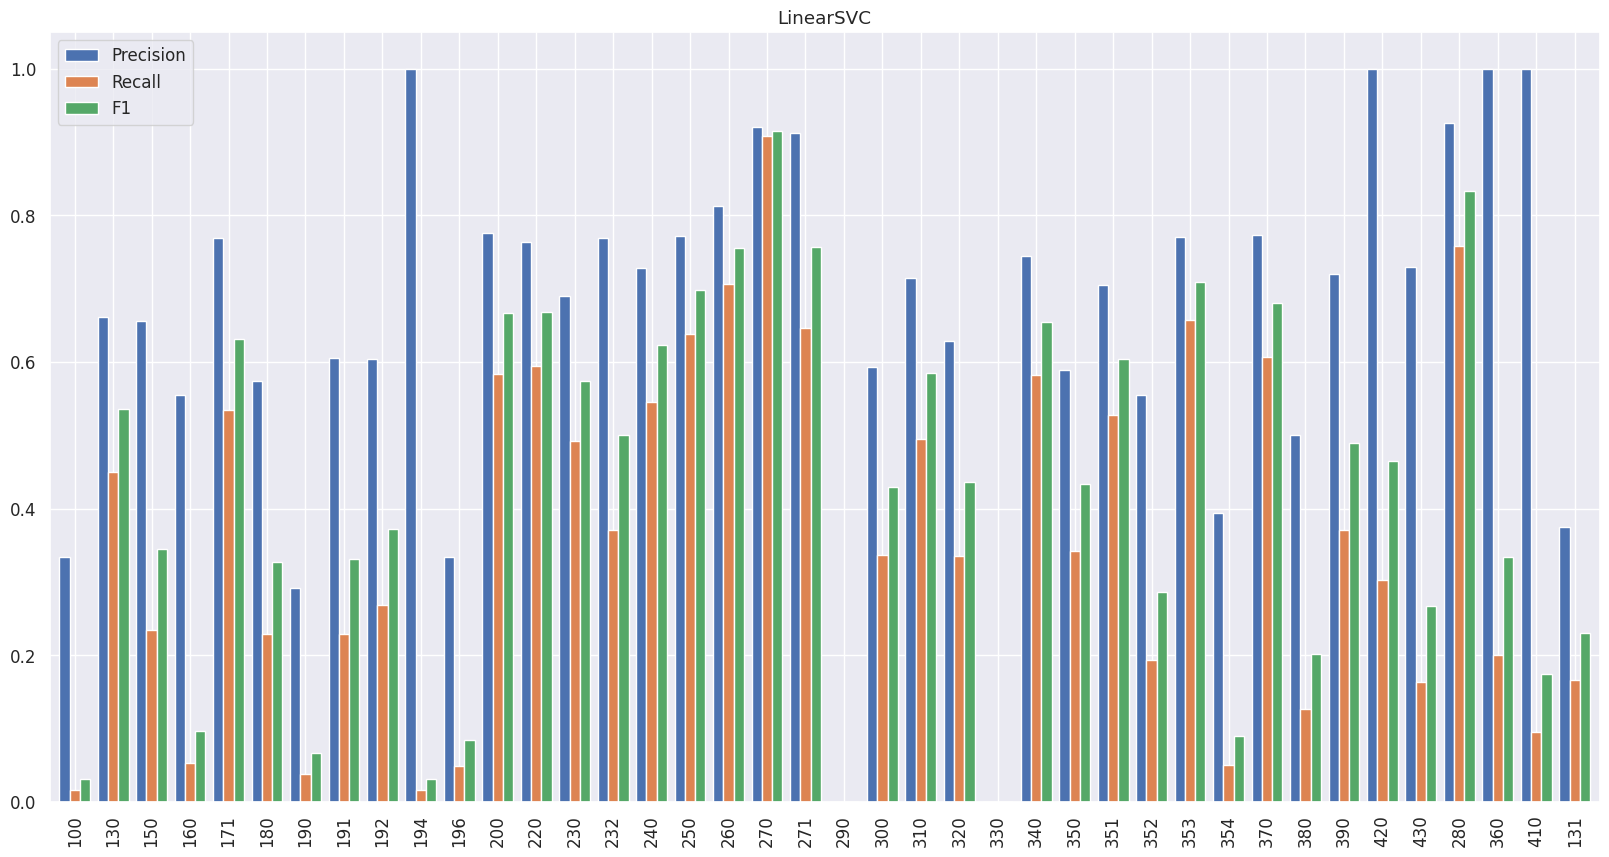

In [38]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)},font_scale=1.1)
frame.T.plot(kind='bar',width=0.8).set_title(mode_name[ii])